# Metric learning for image similarity search using TensorFlow Similarity

**Author:** [Owen Vallis](https://twitter.com/owenvallis)<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
**Description:** Example of using similarity metric learning on CIFAR-10 images.

## Overview

This example is based on the
["Metric learning for image similarity search" example](https://keras.io/examples/vision/metric_learning/).
We aim to use the same data set but implement the model using
[TensorFlow Similarity](https://github.com/tensorflow/similarity).

Metric learning aims to train models that can embed inputs into a
high-dimensional space such that "similar" inputs are pulled closer to each
other and "dissimilar" inputs are pushed farther apart. Once trained, these
models can produce embeddings for downstream systems where such similarity is
useful, for instance as a ranking signal for search or as a form of pretrained
embedding model for another supervised problem.

For a more detailed overview of metric learning, see:

* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* ["Using crossentropy for metric learning" tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)

## Setup

This tutorial will use the [TensorFlow Similarity](https://github.com/tensorflow/similarity) library
to learn and evaluate the similarity embedding.
TensorFlow Similarity provides components that:

* Make training contrastive models simple and fast.
* Make it easier to ensure that batches contain pairs of examples.
* Enable the evaluation of the quality of the embedding.

In [2]:
!pip install tensorflow_similarity

     |████████████████████████████████| 163 kB 5.3 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 4.0 MB 38.0 MB/s 
     |████████████████████████████████| 13.5 MB 40.8 MB/s 
     |████████████████████████████████| 2.8 MB 37.9 MB/s 
     |████████████████████████████████| 188 kB 42.4 MB/s 
     |████████████████████████████████| 1.1 MB 43.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=70b8c14908e6ee68307ea0db92aa0e13420977779cbe6d53a58ca50f2f80cc71
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=253faee81dc11b6458c1b995ec5c84f733a1640637c4daf95020b30e5ea87871
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent
  Attempting uninstall

In [3]:
import random

from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_similarity as tfsim

tfsim.utils.tf_cap_memory()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity:", tfsim.__version__)

TensorFlow: 2.7.0
TensorFlow Similarity: 0.14.8


## Dataset samplers

We will be using the
[CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10)
dataset for this tutorial.

For a similarity model to learn efficiently, each batch must contains at least 2
examples of each class.

To make this easy, tf_similarity offers `Sampler` objects that enable you to set both
the number of classes and the minimum number of examples of each class per
batch.

The train and validation datasets will be created using the
`TFDatasetMultiShotMemorySampler` object. This creates a sampler that loads datasets
from [TensorFlow Datasets](https://www.tensorflow.org/datasets) and yields
batches containing a target number of classes and a target number of examples
per class. Additionally, we can restrict the sampler to only yield the subset of
classes defined in `class_list`, enabling us to train on a subset of the classes
and then test how the embedding generalizes to the unseen classes. This can be
useful when working on few-shot learning problems.

The following cell creates a train_ds sample that:

* Loads the CIFAR-10 dataset from TFDS and then takes the `examples_per_class_per_batch`.
* Ensures the sampler restricts the classes to those defined in `class_list`.
* Ensures each batch contains 10 different classes with 8 examples each.

We also create a validation dataset in the same way, but we limit the total number of
examples per class to 100 and the examples per class per batch is set to the
default of 2.

In [4]:
# This determines the number of classes used during training.
# Here we are using all the classes.
num_known_classes = 10
class_list = random.sample(population=range(10), k=num_known_classes)

classes_per_batch = 10
# Passing multiple examples per class per batch ensures that each example has
# multiple positive pairs. This can be useful when performing triplet mining or
# when using losses like `MultiSimilarityLoss` or `CircleLoss` as these can
# take a weighted mix of all the positive pairs. In general, more examples per
# class will lead to more information for the positive pairs, while more classes
# per batch will provide more varied information in the negative pairs. However,
# the losses compute the pairwise distance between the examples in a batch so
# the upper limit of the batch size is restricted by the memory.
examples_per_class_per_batch = 8

print(
    "Batch size is: "
    f"{min(classes_per_batch, num_known_classes) * examples_per_class_per_batch}"
)

print(" Create Training Data ".center(34, "#"))
train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=min(classes_per_batch, num_known_classes),
    splits="train",
    steps_per_epoch=4000,
    examples_per_class_per_batch=examples_per_class_per_batch,
    class_list=class_list,
)

print("\n" + " Create Validation Data ".center(34, "#"))
val_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
    "cifar10",
    classes_per_batch=classes_per_batch,
    splits="test",
    total_examples_per_class=100,
)

Batch size is: 80
###### Create Training Data ######


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


converting train:   0%|          | 0/50000 [00:00<?, ?it/s]


The initial batch size is 80 (10 classes * 8 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/50000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/50000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/50000 [00:00<?, ?it/s]


##### Create Validation Data #####


converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/1000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/1000 [00:00<?, ?it/s]

## Visualize the dataset

The samplers will shuffle the dataset, so we can get a sense of the dataset by
plotting the first 25 images.

The samplers provide a `get_slice(begin, size)` method that allows us to easily
select a block of samples.

Alternatively, we can use the `generate_batch()` method to yield a batch. This
can allow us to check that a batch contains the expected number of classes and
examples per class.

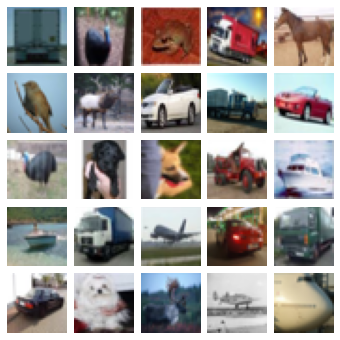

In [5]:
num_cols = num_rows = 5
# Get the first 25 examples.
x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

fig = plt.figure(figsize=(6.0, 6.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for ax, im, label in zip(grid, x_slice, y_slice):
    ax.imshow(im)
    ax.axis("off")

## Embedding model

Next we define a `SimilarityModel` using the Keras Functional API. The model
is a standard convnet with the addition of a `MetricEmbedding` layer that
applies L2 normalization. The metric embedding layer is helpful when using
`Cosine` distance as we only care about the angle between the vectors.

Additionally, the `SimilarityModel` provides a number of helper methods for:

* Indexing embedded examples
* Performing example lookups
* Evaluating the classification
* Evaluating the quality of the embedding space

See the [TensorFlow Similarity documentation](https://github.com/tensorflow/similarity)
for more details.

In [6]:
embedding_size = 256

inputs = keras.layers.Input((32, 32, 3))
x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D((4, 4))(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.GlobalMaxPool2D()(x)
outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)

# building model
model = tfsim.models.SimilarityModel(inputs, outputs)
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                  

## Similarity loss

The similarity loss expects batches containing at least 2 examples of each
class, from which it computes the loss over the pairwise positive and negative
distances. Here we are using `MultiSimilarityLoss()`
([paper](ihttps://arxiv.org/abs/1904.06627)), one of several losses in
[TensorFlow Similarity](https://github.com/tensorflow/similarity). This loss
attempts to use all informative pairs in the batch, taking into account the
self-similarity, positive-similarity, and the negative-similarity.

In [16]:
epochs = 10
learning_rate = 0.002
val_steps = 50

# init similarity loss
loss = tfsim.losses.MultiSimilarityLoss()

# compiling and training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate), loss=loss, steps_per_execution=10,
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds, validation_steps=val_steps
)

Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/10
4000/4000 [==============================] - 251s 63ms/step - loss: 1.5179 - val_loss: 0.8972
Epoch 2/10
4000/4000 [==============================] - 246s 61ms/step - loss: 1.4910 - val_loss: 0.8043
Epoch 3/10
4000/4000 [==============================] - 240s 60ms/step - loss: 1.4394 - val_loss: 0.8566
Epoch 4/10
4000/4000 [==============================] - 236s 59ms/step - loss: 1.4224 - val_loss: 0.8583
Epoch 5/10
4000/4000 [==============================] - 235s 59ms/step - loss: 1.4462 - val_loss: 0.8497
Epoch 6/10
4000/4000 [==============================] - 246s 62ms/step - loss: 1.4413 - val_loss: 0.8285
Epoch 7/10
4000/4000 [==============================] - 240s 60ms/step - loss: 1.4791 - val_loss: 0.7905
Epoch 8/10
4000/4000 [==============================] - 242s 60ms/step - loss: 1.4101 - val_loss: 0.8108
Epoch 9/10
4000/4000 [==============================] - 227s 57ms/step - loss: 1.4

## Indexing

Now that we have trained our model, we can create an index of examples. Here we
batch index the first 200 validation examples by passing the x and y to the index
along with storing the image in the data parameter. The `x_index` values are
embedded and then added to the index to make them searchable. The `y_index` and
data parameters are optional but allow the user to associate metadata with the
embedded example.

In [17]:
x_index, y_index = val_ds.get_slice(begin=0, size=200)
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


## Calibration

Once the index is built, we can calibrate a distance threshold using a matching
strategy and a calibration metric.

Here we are searching for the optimal F1 score while using K=1 as our
classifier. All matches at or below the calibrated threshold distance will be
labeled as a Positive match between the query example and the label associated
with the match result, while all matches above the threshold distance will be
labeled as a Negative match.

Additionally, we pass in extra metrics to compute as well. All values in the
output are computed at the calibrated threshold.

Finally, `model.calibrate()` returns a `CalibrationResults` object containing:

* `"cutpoints"`: A Python dict mapping the cutpoint name to a dict containing the
`ClassificationMetric` values associated with a particular distance threshold,
e.g., `"optimal" : {"acc": 0.90, "f1": 0.92}`.
* `"thresholds"`: A Python dict mapping `ClassificationMetric` names to a list
containing the metric's value computed at each of the distance thresholds, e.g.,
`{"f1": [0.99, 0.80], "distance": [0.0, 1.0]}`.

In [18]:
x_train, y_train = train_ds.get_slice(begin=0, size=1000)
calibration = model.calibrate(
    x_train,
    y_train,
    calibration_metric="f1",
    matcher="match_nearest",
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/950 [00:00<?, ?it/s]


 name       value    distance    precision    recall    binary_accuracy        f1
-------  -------  ----------  -----------  --------  -----------------  --------
optimal     0.96   0.0409586        0.914         1              0.914  0.955068


## Visualization

It may be difficult to get a sense of the model quality from the metrics alone.
A complementary approach is to manually inspect a set of query results to get a
feel for the match quality.

Here we take 10 validation examples and plot them with their 5 nearest
neighbors and the distances to the query example. Looking at the results, we see
that while they are imperfect they still represent meaningfully similar images,
and that the model is able to find similar images irrespective of their pose or
image illumination.

We can also see that the model is very confident with certain images, resulting
in very small distances between the query and the neighbors. Conversely, we see
more mistakes in the class labels as the distances become larger. This is one of
the reasons why calibration is critical for matching applications.


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

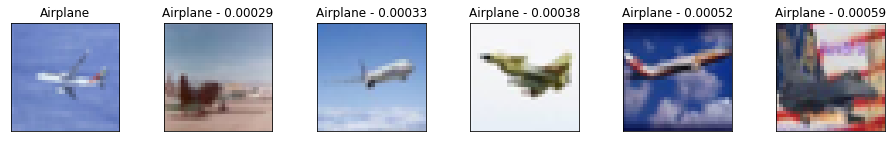

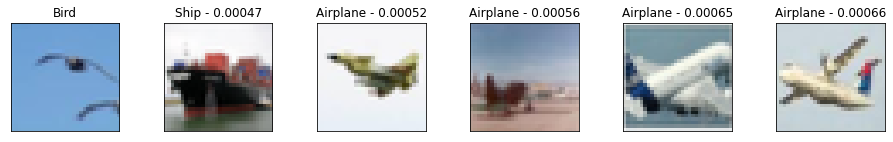

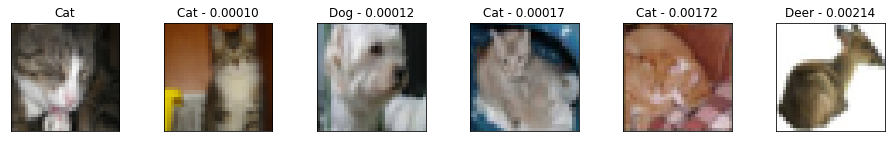

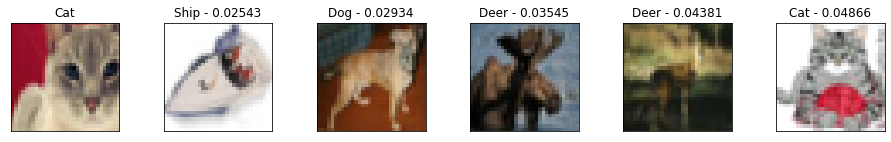

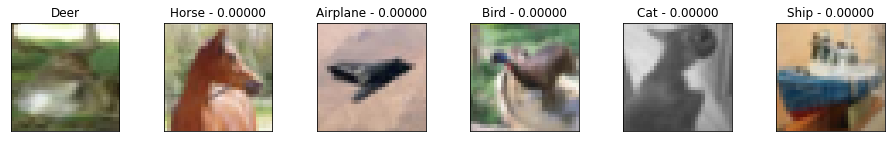

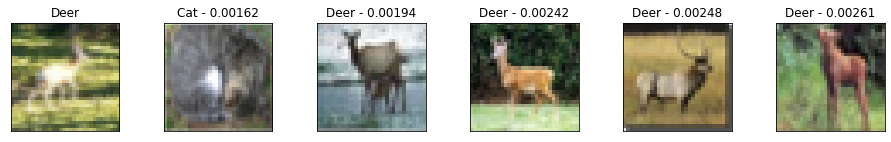

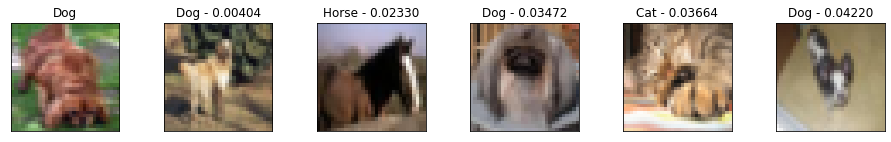

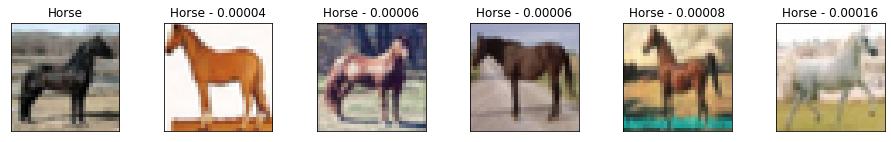

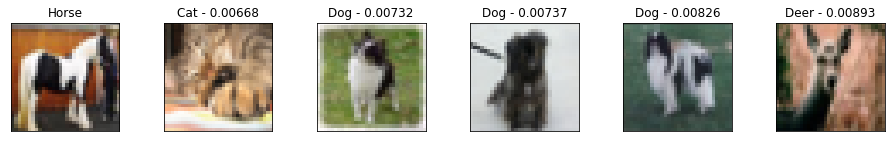

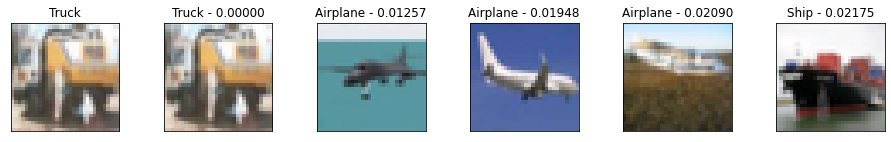

In [19]:
num_neighbors = 5
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
    "Unknown",
]
class_mapping = {c_id: c_lbl for c_id, c_lbl in zip(range(11), labels)}

x_display, y_display = val_ds.get_slice(begin=200, size=10)
# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(
        x_display[idx],
        y_display[idx],
        nns[idx],
        class_mapping=class_mapping,
        fig_size=(16, 2),
    )

## Metrics

We can also plot the extra metrics contained in the `CalibrationResults` to get
a sense of the matching performance as the distance threshold increases.

The following plots show the Precision, Recall, and F1 Score. We can see that
the matching precision degrades as the distance increases, but that the
percentage of the queries that we accept as positive matches (recall) grows
faster up to the calibrated distance threshold.

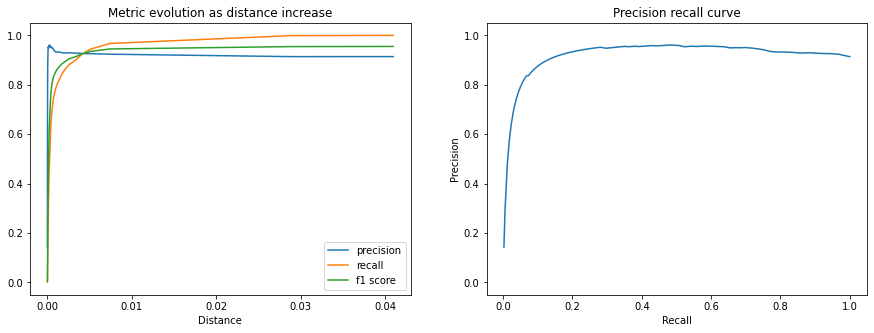

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = calibration.thresholds["distance"]

ax1.plot(x, calibration.thresholds["precision"], label="precision")
ax1.plot(x, calibration.thresholds["recall"], label="recall")
ax1.plot(x, calibration.thresholds["f1"], label="f1 score")
ax1.legend()
ax1.set_title("Metric evolution as distance increase")
ax1.set_xlabel("Distance")
ax1.set_ylim((-0.05, 1.05))

ax2.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax2.set_title("Precision recall curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_ylim((-0.05, 1.05))
plt.show()

We can also take 100 examples for each class and plot the confusion matrix for
each example and their nearest match. We also add an "extra" 10th class to
represent the matches above the calibrated distance threshold.

We can see that most of the errors are between the animal classes with an
interesting number of confusions between Airplane and Bird. Additionally, we see
that only a few of the 100 examples for each class returned matches outside of
the calibrated distance threshold.

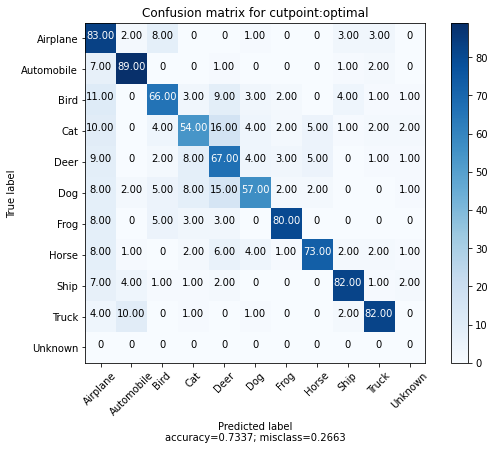

In [21]:
cutpoint = "optimal"

# This yields 100 examples for each class.
# We defined this when we created the val_ds sampler.
x_confusion, y_confusion = val_ds.get_slice(0, -1)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusion matrix for cutpoint:%s" % cutpoint,
    normalize=False,
)

## No Match

We can plot the examples outside of the calibrated threshold to see which images
are not matching any indexed examples.

This may provide insight into what other examples may need to be indexed or
surface anomalous examples within the class.

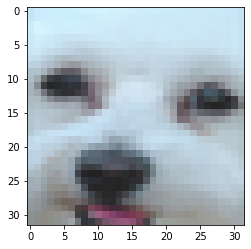

In [22]:
idx_no_match = np.where(np.array(matches) == 10)
no_match_queries = x_confusion[idx_no_match]
if len(no_match_queries):
    plt.imshow(no_match_queries[0])
else:
    print("All queries have a match below the distance threshold.")

## Visualize clusters

One of the best ways to quickly get a sense of the quality of how the model is
doing and understand it's short comings is to project the embedding into a 2D
space.

This allows us to inspect clusters of images and understand which classes are
entangled.

In [23]:
# Each class in val_ds was restricted to 100 examples.
num_examples_to_clusters = 1000
thumb_size = 96
plot_size = 800
vx, vy = val_ds.get_slice(0, num_examples_to_clusters)

# Uncomment to run the interactive projector.
tfsim.visualization.projector(
    model.predict(vx),
    labels=vy,
    images=vx,
    class_mapping=class_mapping,
    image_size=thumb_size,
    plot_size=plot_size,
)

perfoming projection using UMAP


generating diplayabe images:   0%|          | 0/1000 [00:00<?, ?it/s]